# Forest biomass model (cosine forcing)

We want to solve the system
\begin{align}
x' &= - x + 3y, \\
y' &= - 3y + 5z, \\
z' &= - 5z + Z_f(1+\cos\omega t).
\end{align}
The eigenvalues are $-1$, $-3$, and $-5$. The change of coordinate matrix made of the eigenvectors is
\begin{equation}
P = \begin{pmatrix} 1 & 3 & 15 \\ 0 & 2 & -20 \\ 0 & 0 & 8 \end{pmatrix},
\end{equation}
which inverse reads
\begin{equation}
P^{-1} = \begin{pmatrix} 1 & -\frac32 & -\frac{45}8 \\ 0 & \frac12 & \frac54 \\ 0 & 0 & \frac18 \end{pmatrix}.
\end{equation}
Therefore
\begin{equation}
\exp(tA) 
= P \begin{pmatrix} e^{-t} & 0 & 0 \\ 0 & e^{-3t} & 0 \\ 0 & 0 & e^{-5t} \end{pmatrix} P^{-1}
= \begin{pmatrix} e^{-t} & \frac32e^{-t}-\frac32e^{-3t} & \frac{15}8e^{-t}-\frac{15}4e^{-3t}+\frac{15}8e^{-5t} \\ 0 & e^{-3t} & \frac52e^{-3t}-\frac52e^{-5t} \\ 0 & 0 & e^{-5t} \end{pmatrix}.
\end{equation}
We will take $(0,0,z_0)$ as initial data (only living trees).

## Exact solution

\begin{align}
x(t) &= \frac{15}8(e^{-t}-2e^{-3t}+e^{-5t})z_0 + \frac18(8-15e^{-t}+10e^{-3t}-3e^{-5t})Z_f \\
&+ 15 \dfrac{3(5-3\omega^2)\cos\omega t + \omega(23-\omega^2)\sin\omega t}{(1+\omega^2)(9+\omega^2)(25+\omega^2)}Z_f + \frac{15}8 \left(-\dfrac{e^{-t}}{1+\omega^2}+6\dfrac{e^{-3t}}{9+\omega^2}-5\dfrac{e^{-5t}}{25+\omega^2}\right)Z_f, \\
y(t) &= \frac52(e^{-3t}-e^{-5t})z_0 + \frac16(2-5e^{-3t}+3e^{-5t})Z_f \\
&+ \frac52 \dfrac{2(15-\omega^2)\cos\omega t + 16\omega\sin\omega t}{(9+\omega^2)(25+\omega^2)}Z_f + \frac52 \left(- 3\dfrac{e^{-3t}}{9+\omega^2} + 5\dfrac{e^{-5t}}{25+\omega^2}\right)Z_f, \\
z(t) &= e^{-5t}z_0 + \frac15(1-e^{-5t})Z_f + \dfrac{5\cos\omega t+\omega\sin\omega t-5e^{-5t}}{25+\omega^2}Z_f.
\end{align}

In [1]:
%matplotlib inline
from math import exp, cos, sin, pi
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

def exact(z0, Zf, omega, T):
    exp1 = np.exp(-T)
    exp3 = np.exp(-3*T)
    exp5 = np.exp(-5*T)
    coso = np.cos(omega*T)
    sino = np.sin(omega*T)
    omega2 = omega * omega
    Den1 = 1 + omega2
    Den3 = 9 + omega2
    Den5 = 25 + omega2
    x = 1.875 * (exp1 - 2 * exp3 + exp5) * z0 \
    + 0.125 * (8 - 15 * exp1 + 10 * exp3 - 3 * exp5) * Zf \
    + 1.875 * (24 * (5-3*omega2) * coso + 8 * omega * (23-omega2) * sino \
               - Den5 * Den3 * exp1 + 6 * Den5 * Den1 * exp3 \
               - 5 * Den1 * Den3 * exp5) / Den5 / Den3 / Den1 * Zf
    y = 2.5 * (exp3 - exp5) * z0 \
    + (2 - 5 * exp3 + 3 * exp5) / 6 * Zf \
    + 2.5 * (2 * (15-omega2) * coso + 16 * omega * sino \
                - 3 * Den5 * exp3 + 5 * Den3 * exp5) / Den5 / Den3 * Zf
    z = exp5 * z0 + .2 * (1 - exp5) * Zf + (5* coso + omega * sino - 5 * exp5) / Den5 * Zf
    return x, y, z

In [2]:
A = np.array([[-1, 3, 0], [0, -3, 5],[0, 0, -5]])
vp, P = np.linalg.eig(A)
print(P)
invP = np.linalg.inv(P)
print(invP)
print(np.linalg.inv(A))

[[ 1.         -0.83205029  0.57145449]
 [ 0.          0.5547002  -0.76193932]
 [ 0.          0.          0.30477573]]
[[1.         1.5        1.875     ]
 [0.         1.80277564 4.50693909]
 [0.         0.         3.28110119]]
[[-1.         -1.         -1.        ]
 [-0.         -0.33333333 -0.33333333]
 [-0.         -0.         -0.2       ]]


## Data for tests

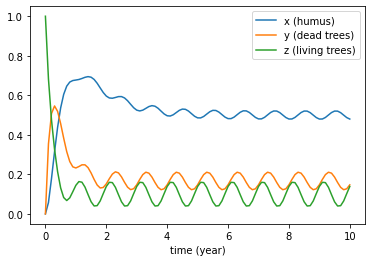

In [3]:
Tmax = 10
dt = .1
n = int(Tmax / dt)
T = dt * np.array(range(n+1))
z0, Zf, omega = 1, .5, 2*pi
nl = 'half'
XYZExact = exact(z0, Zf, omega, T)

plt.plot(T, XYZExact[0], label="x (humus)")
plt.plot(T, XYZExact[1], label="y (dead trees)")
plt.plot(T, XYZExact[2], label="z (living trees)")
plt.xlabel('time (year)')
plt.legend()
plt.savefig('Plots/Biomass_cosine_exact.png', format='png')
plt.savefig('Plots/Biomass_cosine_exact.pdf', format='pdf')

## Explicit Euler

\begin{align}
x_{k+1} &= (1 - \Delta t) x_k + 3\Delta t y_k, \\
y_{k+1} &= (1 - 3\Delta t) y_k + 5\Delta t z_k, \\
z_{k+1} &= (1 - 5\Delta t) z_k + \Delta t Z_f(1+\cos\omega t_k).
\end{align}

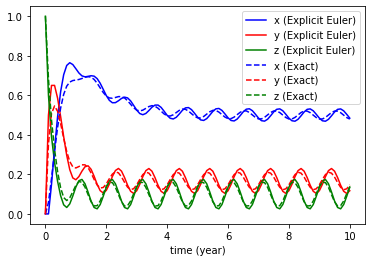

In [4]:
def xyz_explicit_Euler(z0, Zf, omega, dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i, t in enumerate(T[1:]):
        Z[i+1] = (1 - 5 * dt) * Z[i] + dt * (1 + cos(omega*T[i])) * Zf
        Y[i+1] = (1 - 3 * dt) * Y[i] + 5 * dt * Z[i]
        X[i+1] = (1 - dt) * X[i] + 3 * dt * Y[i]
    return X, Y, Z
        
XYZEulerE = xyz_explicit_Euler(z0, Zf, omega, dt, Tmax)
plt.plot(T, XYZEulerE[0] ,'b', label="x (Explicit Euler)")
plt.plot(T, XYZEulerE[1] ,'r', label="y (Explicit Euler)")
plt.plot(T, XYZEulerE[2] ,'g', label="z (Explicit Euler)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Implicit Euler

\begin{align}
x_{k+1} &= \frac1{1 + \Delta t} (x_k + 3\Delta t y_{k+1}), \\
y_{k+1} &= \frac1{1 + 3\Delta t} (y_k + 5\Delta t z_{k+1}), \\
z_{k+1} &= \frac1{1 + 5\Delta t} (z_k + \Delta t Z_f (1+\cos\omega t
_{k+1})).
\end{align}

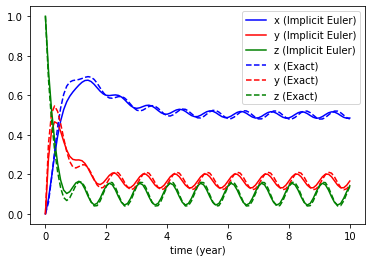

In [5]:
def xyz_implicit_Euler(z0, Zf, omega, dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i, t in enumerate(T[1:]):
        Z[i+1] = (Z[i] + dt * (1+cos(omega*T[i+1])) * Zf) / (1 + 5 * dt)
        Y[i+1] = (Y[i] + 5 * dt * Z[i+1]) / (1 + 3 * dt)
        X[i+1] = (X[i] + 3 * dt * Y[i+1]) / (1 + dt)
    return X, Y, Z
        
XYZEulerI = xyz_implicit_Euler(z0, Zf, omega, dt, Tmax)
plt.plot(T, XYZEulerI[0] ,'b', label="x (Implicit Euler)")
plt.plot(T, XYZEulerI[1] ,'r', label="y (Implicit Euler)")
plt.plot(T, XYZEulerI[2] ,'g', label="z (Implicit Euler)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Our scheme

\begin{align}
\alpha_0(\Delta t) & = \frac{15}8 e^{-\Delta t} - \frac54 e^{-3\Delta t} + \frac38 e^{-5\Delta t},\\
\alpha_1(\Delta t) & = e^{-\Delta t} - \frac32 e^{-3\Delta t} + \frac12 e^{-5\Delta t},\\
\alpha_2(\Delta t) & = \frac18 e^{-\Delta t} - \frac14 e^{-3\Delta t} + \frac18 e^{-5\Delta t}.
\end{align}
\begin{equation}
Z_k = \begin{cases}
(1+\cos\omega t_k) Z_f & \text{('left' approximation)} \\
(1+\cos\omega t_{k+1}) Z_f & \text{('right' approximation)} \\
(1+\cos\omega t_{k+\frac12}) Z_f & \text{('middle' approximation)} \\
\left(1+\cos\omega \frac{t_k+t_{k+1}}2\right) Z_f & \text{('half' approximation)} \\
\left(1+\dfrac{\sin\omega t_{k+1}-\sin\omega t_k}{\omega\Delta t}\right) Z_f & \text{('mean' approximation)} \\
\end{cases}
\end{equation}
\begin{equation}
X_{k+1} = (\alpha_0(\Delta t) + \alpha_1(\Delta t) A + \alpha_2(\Delta t) A^2)(X_k+A^{-1}Z_k) - A^{-1}Z_k.
\end{equation}

In [6]:
def B(Ti, dt, omega, Zf, nl):
    if nl == 'left':
        return Zf * (1 + cos(omega*Ti))
    elif nl == 'right':
        return Zf * (1 + cos(omega*(Ti+dt)))
    elif nl == 'middle':
        return Zf * (1 + cos(omega*(Ti+dt/2)))
    elif nl == 'half':
        return Zf * (1 + .5 * cos(omega*(Ti+dt)) + .5 * cos(omega*Ti))
    elif nl == 'mean':
        return Zf * (1 + (sin(omega*(Ti+dt))-sin(omega*Ti))/omega/dt) 

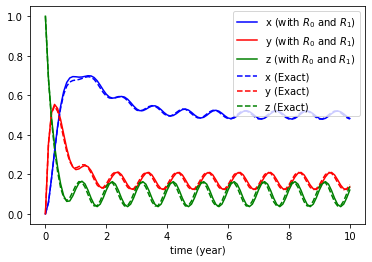

In [7]:
def xyz_NSFD(z0, Zf, omega, dt, Tmax, nl):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    exp1 = exp(-dt)
    exp3 = exp(-3*dt)
    exp5 = exp(-5*dt)
    alpha0 = 1.875 * exp1 - 1.25 * exp3 + 0.375 * exp5
    alpha1 = exp1 - 1.5 * exp3 + .5 * exp5
    alpha2 = .125  * exp1 - .25 * exp3 + .125 * exp5
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n): 
        Zk = B(T[i], dt, omega, Zf, nl)          
        Z[i+1] = (alpha0 - 5 * alpha1 + 25 * alpha2) * (Z[i] - Zk/5)  + Zk/5
        Y[i+1] = (alpha0 - 3 * alpha1 + 9 * alpha2) * (Y[i] - Zk/3) \
        + (5 * alpha1 - 40 * alpha2) * (Z[i] - Zk/5) + Zk/3 
        X[i+1] = (alpha0 - alpha1 + alpha2) * (X[i] - Zk) \
        + (3 * alpha1 - 12 * alpha2) * (Y[i] - Zk/3) \
        + 15 * alpha2 * (Z[i] - Zk/5) + Zk 
    return X, Y, Z
        
XYZNSFD = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'left')
plt.plot(T, XYZNSFD[0] ,'b', label="x (with $R_0$ and $R_1$)")
plt.plot(T, XYZNSFD[1] ,'r', label="y (with $R_0$ and $R_1$)")
plt.plot(T, XYZNSFD[2] ,'g', label="z (with $R_0$ and $R_1$)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend(loc='upper right');

Let us replace the $\alpha_j$ by their order 3 approximation.
\begin{align}
\beta_0(\Delta t) & = \frac{15}8 e^{-\Delta t} - \frac54 e^{-3\Delta t} + \frac38 e^{-5\Delta t},\\
\beta_1(\Delta t) & = e^{-\Delta t} - \frac32 e^{-3\Delta t} + \frac12 e^{-5\Delta t},\\
\beta_2(\Delta t) & = \frac18 e^{-\Delta t} - \frac14 e^{-3\Delta t} + \frac18 e^{-5\Delta t}.
\end{align}

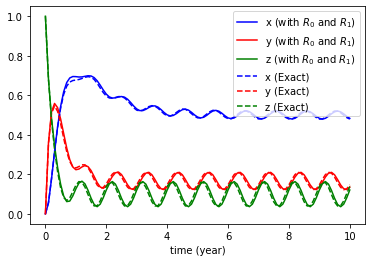

In [8]:
def xyz_NSFD2(z0, Zf, omega, dt, Tmax, nl):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    beta0 = 1 - 2.5 * dt * dt * dt
    beta1 = dt - 23/6 * dt * dt * dt
    beta2 = .5 * dt * dt - 1.5 * dt *dt * dt
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n):  
        Zk = B(T[i], dt, omega, Zf, nl)         
        Z[i+1] = (beta0 - 5 * beta1 + 25 * beta2) * (Z[i] - Zk/5) + Zk/5
        Y[i+1] = (beta0 - 3 * beta1 + 9 * beta2) * (Y[i] - Zk/3) \
        + (5 * beta1 - 40 * beta2) * (Z[i] - Zk/5) + Zk/3
        X[i+1] = (beta0 - beta1 + beta2) * (X[i] - Zk) \
        + (3 * beta1 - 12 * beta2) * (Y[i] - Zk/3) + 15 * beta2 * (Z[i] - Zk/5) + Zk
    return X, Y, Z
        
XYZNSFD2 = xyz_NSFD2(z0, Zf, omega, dt, Tmax, 'left')
plt.plot(T, XYZNSFD2[0] ,'b', label="x (with $R_0$ and $R_1$)")
plt.plot(T, XYZNSFD2[1] ,'r', label="y (with $R_0$ and $R_1$)")
plt.plot(T, XYZNSFD2[2] ,'g', label="z (with $R_0$ and $R_1$)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend(loc='upper right');

## Mickens' scheme

We apply the general procedure for each equation separately. This yields
\begin{align}
x_{k+1} &= x_k + (1-e^{-\Delta t}) (- x_k + 3 y_k), \\
y_{k+1} &= y_k + \frac{1-e^{-3\Delta t}}3 (- 3 y_k + 5 z_k), \\
z_{k+1} &= z_k + \frac{1-e^{-5\Delta t}}5 (-5 z_k + Z_k).
\end{align}

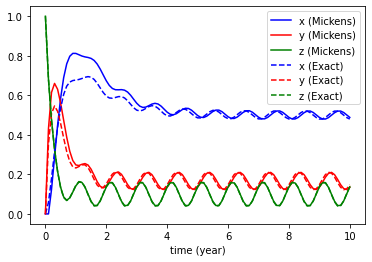

In [9]:
def xyz_Mickens(z0, Zf, omega, dt, Tmax, nl):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    dtx = 1 - exp(-dt)
    dty = (1 - exp(-3*dt)) / 3
    dtz = (1 - exp(-5*dt)) / 5
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n):
        Zk = B(T[i], dt, omega, Zf, nl)      
        Z[i+1] = Z[i] + dtz * (-5 * Z[i] + Zk)
        Y[i+1] = Y[i] + dty * (-3 * Y[i] + 5 * Z[i])
        X[i+1] = X[i] + dtx * (- X[i] + 3 * Y[i])
    return X, Y, Z
        
XYZMickens = xyz_Mickens(z0, Zf, omega, dt, Tmax, nl)
plt.plot(T, XYZMickens[0] ,'b', label="x (Mickens)")
plt.plot(T, XYZMickens[1] ,'r', label="y (Mickens)")
plt.plot(T, XYZMickens[2] ,'g', label="z (Mickens)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Error analysis

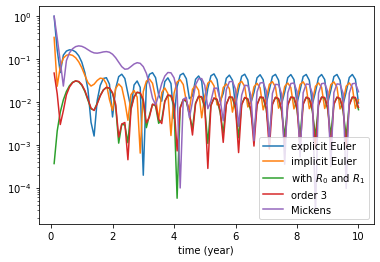

In [10]:
ErrorEulerE = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZEulerE[0][1:], XYZExact[0][1:])])
ErrorEulerI = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZEulerI[0][1:], XYZExact[0][1:])])
ErrorNSFD = np.array([abs((x - xe) / xe) \
                      for x, xe in zip(XYZNSFD[0][1:], XYZExact[0][1:])])
ErrorNSFD2 = np.array([abs((x - xe) / xe) \
                       for x, xe in zip(XYZNSFD2[0][1:], XYZExact[0][1:])])
ErrorMickens = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZMickens[0][1:], XYZExact[0][1:])])

plt.semilogy(T[1:], ErrorEulerE, label="explicit Euler")
plt.semilogy(T[1:], ErrorEulerI, label="implicit Euler")
plt.semilogy(T[1:], ErrorNSFD, label="with $R_0$ and $R_1$")
plt.semilogy(T[1:], ErrorNSFD2, label="order 3")
plt.semilogy(T[1:], ErrorMickens, label="Mickens")
plt.xlabel("time (year)")
plt.legend(loc='lower right');

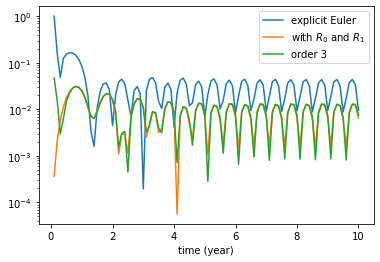

In [11]:
plt.semilogy(T[1:], ErrorEulerE, label="explicit Euler")
plt.semilogy(T[1:], ErrorNSFD, label="with $R_0$ and $R_1$")
plt.semilogy(T[1:], ErrorNSFD2, label="order 3")
plt.xlabel('time (year)')
plt.legend(loc='upper right');

In [12]:
I = np.eye(3,3)
A = np.array([[-1, 3, 0], [0, -3, 5],[0, 0, -5]])
A2 = A @ A
exp1 = exp(-dt)
exp2 = exp(-2*dt)
exp3 = exp(-3*dt)
exp5 = exp(-5*dt)
expdtA = np.array([[exp1, 1.5 * exp1 - 1.5 * exp3, 1.875 * exp1 - 3.75 * exp3 + 1.875 * exp5],
                 [0, exp3, 2.5 * exp3 - 2.5 * exp5], [0, 0, exp5]])
print(expdtA)
alpha0 = 1.875 * exp1 - 1.25 * exp3 + 0.375 * exp5
alpha1 = exp1 - 1.5 * exp3 + .5 * exp5
alpha2 = .125  * exp1 - .25 * exp3 + .125 * exp5
expdtAbis = alpha0 * I + alpha1 * A + alpha2 * A2
print(expdtAbis)
beta0 = 1 - 2.5 * dt * dt * dt
beta1 = dt - 23/6 * dt * dt * dt
beta2 = .5 * dt * dt - 1.5 * dt *dt * dt
expdtAter = beta0 * I + beta1 * A + beta2 * A2
print(expdtAter)

[[0.90483742 0.2460288  0.05574682]
 [0.         0.74081822 0.3357189 ]
 [0.         0.         0.60653066]]
[[0.90483742 0.2460288  0.05574682]
 [0.         0.74081822 0.3357189 ]
 [0.         0.         0.60653066]]
[[0.90483333 0.2465     0.0525    ]
 [0.         0.7405     0.34083333]
 [0.         0.         0.60416667]]


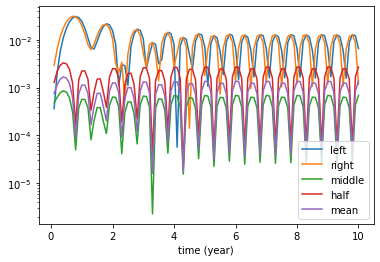

In [13]:
XYZNSFD_left = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'left')
XYZNSFD_right = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'right')
XYZNSFD_middle = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'middle')
XYZNSFD_half = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'half')
XYZNSFD_mean = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'mean')

ErrorNSFD_left = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD_left[0][1:], XYZExact[0][1:])])
ErrorNSFD_right = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD_right[0][1:], XYZExact[0][1:])])
ErrorNSFD_middle = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD_middle[0][1:], XYZExact[0][1:])])
ErrorNSFD_half = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD_half[0][1:], XYZExact[0][1:])])
ErrorNSFD_mean = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD_mean[0][1:], XYZExact[0][1:])])

plt.semilogy(T[1:], ErrorNSFD_left, label='left')
plt.semilogy(T[1:], ErrorNSFD_right, label='right')
plt.semilogy(T[1:], ErrorNSFD_middle, label='middle')
plt.semilogy(T[1:], ErrorNSFD_half, label='half')
plt.semilogy(T[1:], ErrorNSFD_mean, label='mean')
plt.xlabel('time (year)')
plt.legend(loc='lower right')
plt.savefig('Plots/Biomass_cosine_NSFD.png', format='png');
plt.savefig('Plots/Biomass_cosine_NSFD.pdf', format='pdf');

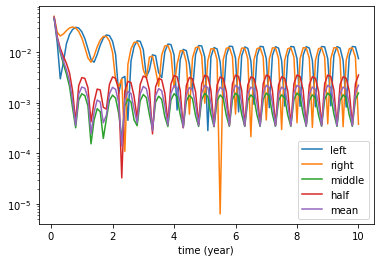

In [14]:
XYZNSFD2_left = xyz_NSFD2(z0, Zf, omega, dt, Tmax, 'left')
XYZNSFD2_right = xyz_NSFD2(z0, Zf, omega, dt, Tmax, 'right')
XYZNSFD2_middle = xyz_NSFD2(z0, Zf, omega, dt, Tmax, 'middle')
XYZNSFD2_half = xyz_NSFD2(z0, Zf, omega, dt, Tmax, 'half')
XYZNSFD2_mean = xyz_NSFD2(z0, Zf, omega, dt, Tmax, 'mean')

ErrorNSFD2_left = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD2_left[0][1:], XYZExact[0][1:])])
ErrorNSFD2_right = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD2_right[0][1:], XYZExact[0][1:])])
ErrorNSFD2_middle = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD2_middle[0][1:], XYZExact[0][1:])])
ErrorNSFD2_half = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD2_half[0][1:], XYZExact[0][1:])])
ErrorNSFD2_mean = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZNSFD2_mean[0][1:], XYZExact[0][1:])])

plt.semilogy(T[1:], ErrorNSFD2_left, label='left')
plt.semilogy(T[1:], ErrorNSFD2_right, label='right')
plt.semilogy(T[1:], ErrorNSFD2_middle, label='middle')
plt.semilogy(T[1:], ErrorNSFD2_half, label='half')
plt.semilogy(T[1:], ErrorNSFD2_mean, label='mean')
plt.xlabel('time (year)')
plt.legend(loc='lower right')
plt.savefig('Plots/Biomass_cosine_NSFD2.png', format='png');
plt.savefig('Plots/Biomass_cosine_NSFD2.pdf', format='pdf');

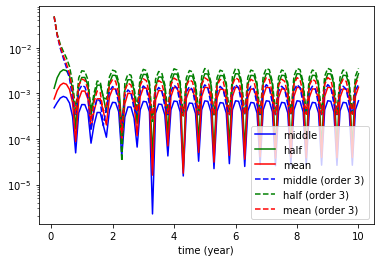

In [15]:
plt.semilogy(T[1:],ErrorNSFD_middle,'b', label='middle')
plt.semilogy(T[1:],ErrorNSFD_half,'g', label='half')
plt.semilogy(T[1:],ErrorNSFD_mean,'r', label='mean')
plt.semilogy(T[1:],ErrorNSFD2_middle,'b--', label='middle (order 3)')
plt.semilogy(T[1:],ErrorNSFD2_half,'g--', label='half (order 3)')
plt.semilogy(T[1:],ErrorNSFD2_mean,'r--', label='mean (order 3)')
plt.xlabel('time (year)')
plt.legend(loc='lower right');

## Order analysis

In [16]:
def Error(XYZ, dt, norm):
    XError = np.linalg.norm(XYZ[0] - XYZExact[0], ord=norm)
    YError = np.linalg.norm(XYZ[1] - XYZExact[1], ord=norm)
    ZError = np.linalg.norm(XYZ[2] - XYZExact[2], ord=norm)
    return dt*XError + dt*YError + dt*ZError

### Method comparison

[[5.90501563e-01 4.15356776e-01 4.32674241e-02 4.54011485e-02
  4.75589227e-01]
 [2.63507113e-01 2.22604635e-01 1.09785908e-02 1.08771630e-02
  2.21382112e-01]
 [4.89879480e-02 4.73468390e-02 4.38822407e-04 4.37116185e-04
  4.16283912e-02]
 [4.82182237e-03 4.80543525e-03 4.38622022e-06 4.38447523e-06
  4.10294450e-03]
 [2.40882101e-03 2.40472423e-03 1.09652498e-06 1.09630635e-06
  2.04981056e-03]]


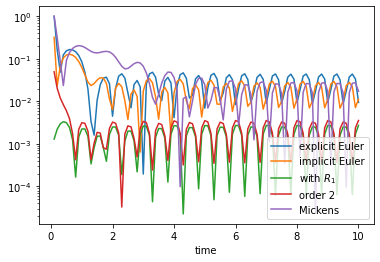

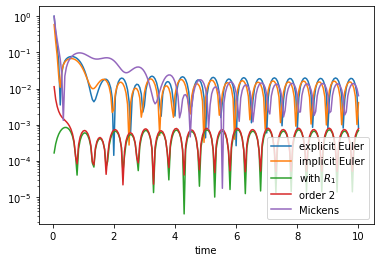

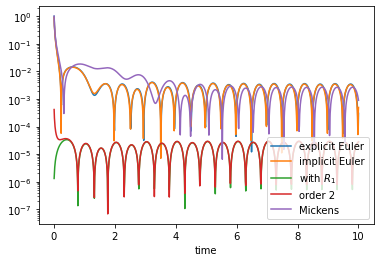

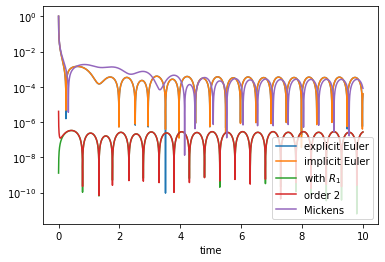

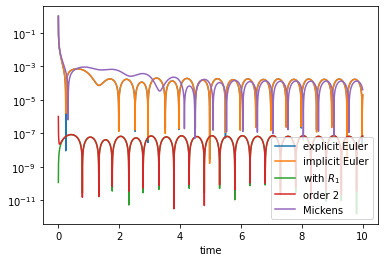

In [17]:
dt_tab = [0.1, 0.05, 0.01, 0.001, 0.0005]
errors = np.zeros((len(dt_tab), 5))
for (j, dt) in enumerate(dt_tab):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    XYZExact = exact(z0, Zf, omega, T)
    XYZEulerE = xyz_explicit_Euler(z0, Zf, omega, dt, Tmax)
    XYZEulerI = xyz_implicit_Euler(z0, Zf, omega, dt, Tmax)
    XYZNSFD = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'half')
    XYZNSFD2 = xyz_NSFD2(z0, Zf, omega, dt, Tmax, 'half')
    XYZMickens = xyz_Mickens(z0, Zf, omega, dt, Tmax, 'half')
    # Errors
    errors[j,0] = Error(XYZEulerE, dt, 1)
    errors[j,1] = Error(XYZEulerI, dt, 1)
    errors[j,2] = Error(XYZNSFD, dt, 1)
    errors[j,3] = Error(XYZNSFD2, dt, 1)
    errors[j,4] = Error(XYZMickens, dt, 1)
    # Plots
    plt.figure(j)
    ErrorEulerE = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZEulerE[0][1:], XYZExact[0][1:])])
    ErrorEulerI = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZEulerI[0][1:], XYZExact[0][1:])])
    ErrorNSFD = np.array([abs((x - xe) / xe) \
              for x, xe in zip(XYZNSFD[0][1:], XYZExact[0][1:])])
    ErrorNSFD2 = np.array([abs((x - xe) / xe) \
               for x, xe in zip(XYZNSFD2[0][1:], XYZExact[0][1:])])
    ErrorMickens = np.array([abs((x - xe) / xe) \
                 for x, xe in zip(XYZMickens[0][1:], XYZExact[0][1:])])
    plt.semilogy(T[1:], ErrorEulerE, label="explicit Euler")
    plt.semilogy(T[1:], ErrorEulerI, label="implicit Euler")
    plt.semilogy(T[1:], ErrorNSFD, label="with $R_1$")
    plt.semilogy(T[1:], ErrorNSFD2, label="order 2")
    plt.semilogy(T[1:], ErrorMickens, label="Mickens")
    plt.xlabel('time')
    plt.legend(loc='lower right')
    plt.savefig('Plots/Biomass_cosine_'+str(dt_tab[j])[2:]+'.png', format='png')
    plt.savefig('Plots/Biomass_cosine_'+str(dt_tab[j])[2:]+'.pdf', format='pdf')
print(errors)

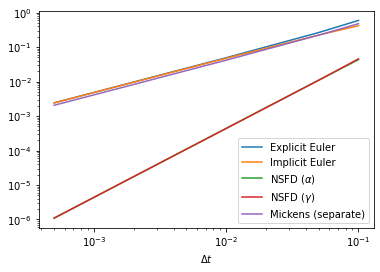

In [18]:
methods_tab = ['Explicit Euler', 'Implicit Euler',
               r'NSFD ($\alpha$)', r'NSFD ($\gamma$)', 'Mickens (separate)']

plt.loglog(dt_tab,errors)
plt.xlabel(r'$\Delta t$')
plt.legend(methods_tab)
plt.savefig('Plots/Biomass_cosine_orders.png', format='png')
plt.savefig('Plots/Biomass_cosine_orders.pdf', format='pdf')

In [19]:
orders = [linregress(np.log(dt_tab),np.log(errors[:,k])).slope for k in range(5)]
for (method,order) in zip(methods_tab,orders):
    print(method, ':', order)

Explicit Euler : 1.0320091741375979
Implicit Euler : 0.9758280627084026
NSFD ($\alpha$) : 1.9984952849454498
NSFD ($\gamma$) : 2.003404507627158
Mickens (separate) : 1.0243712276376065


### Approximation comparison

[[2.82207249e-01 2.59934391e-01 1.94474588e-02 4.32674241e-02
  2.42115699e-02]
 [1.36917367e-01 1.32406986e-01 4.80095444e-03 1.09785908e-02
  6.03890770e-03]
 [2.70242974e-02 2.68262194e-02 1.92054480e-04 4.38822407e-04
  2.41551297e-04]
 [2.69218661e-03 2.69024889e-03 1.91976264e-06 4.38622022e-06
  2.41442799e-06]
 [1.34581401e-03 1.34532966e-03 4.79932606e-07 1.09652498e-06
  6.03591864e-07]]


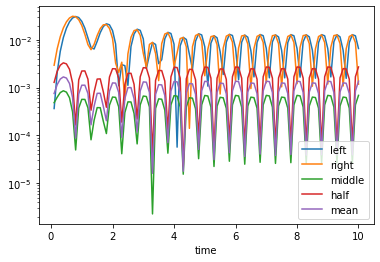

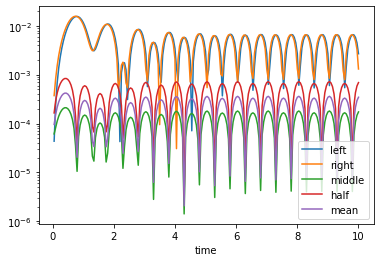

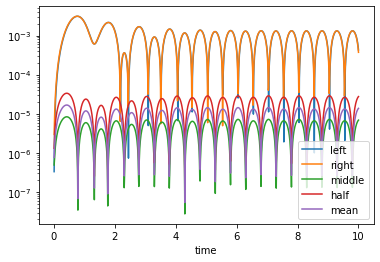

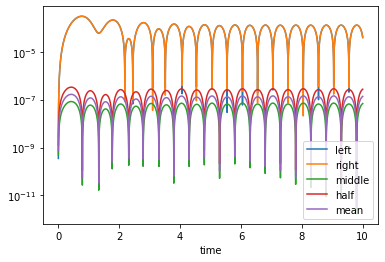

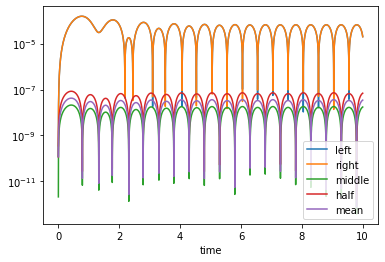

In [20]:
dt_tab = [0.1, 0.05, 0.01, 0.001, 0.0005]
errors = np.zeros((len(dt_tab), 5))
for (j, dt) in enumerate(dt_tab):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    XYZExact = exact(z0, Zf, omega, T)
    XYZNSFD_left = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'left')
    XYZNSFD_right = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'right')
    XYZNSFD_middle = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'middle')
    XYZNSFD_half = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'half')
    XYZNSFD_mean = xyz_NSFD(z0, Zf, omega, dt, Tmax, 'mean')
    # Errors
    errors[j,0] = Error(XYZNSFD_left, dt, 1)
    errors[j,1] = Error(XYZNSFD_right, dt, 1)
    errors[j,2] = Error(XYZNSFD_middle, dt, 1)
    errors[j,3] = Error(XYZNSFD_half, dt, 1)
    errors[j,4] = Error(XYZNSFD_mean, dt, 1)
    # Plots
    plt.figure(j)
    ErrorNSFD_left = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZNSFD_left[0][1:], XYZExact[0][1:])])
    ErrorNSFD_right = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZNSFD_right[0][1:], XYZExact[0][1:])])
    ErrorNSFD_middle = np.array([abs((x - xe) / xe) \
              for x, xe in zip(XYZNSFD_middle[0][1:], XYZExact[0][1:])])
    ErrorNSFD_half = np.array([abs((x - xe) / xe) \
               for x, xe in zip(XYZNSFD_half[0][1:], XYZExact[0][1:])])
    ErrorNSFD_mean = np.array([abs((x - xe) / xe) \
                 for x, xe in zip(XYZNSFD_mean[0][1:], XYZExact[0][1:])])
    plt.semilogy(T[1:], ErrorNSFD_left, label="left")
    plt.semilogy(T[1:], ErrorNSFD_right, label="right")
    plt.semilogy(T[1:], ErrorNSFD_middle, label="middle")
    plt.semilogy(T[1:], ErrorNSFD_half, label="half")
    plt.semilogy(T[1:], ErrorNSFD_mean, label="mean")
    plt.xlabel('time')
    plt.legend(loc='lower right')
    plt.savefig('Plots/Biomass_cosine_'+str(dt_tab[j])[2:]+'.png', format='png')
    plt.savefig('Plots/Biomass_cosine_'+str(dt_tab[j])[2:]+'.pdf', format='pdf')
print(errors)

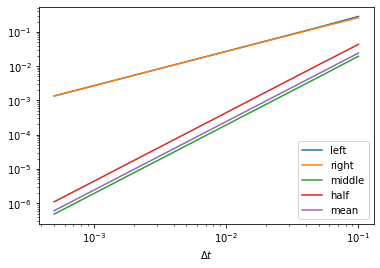

In [21]:
approx_tab = ['left', 'right', 'middle', 'half', 'mean']

plt.loglog(dt_tab,errors)
plt.legend(approx_tab)
plt.xlabel(r'$\Delta t$')
plt.savefig('Plots/Biomass_cosine_B_orders.png', format='png')
plt.savefig('Plots/Biomass_cosine_B_orders.pdf', format='pdf')

In [22]:
orders = [linregress(np.log(dt_tab),np.log(errors[:,k])).slope for k in range(5)]
for (approx,order) in zip(approx_tab,orders):
    print(approx, ':', order)

left : 1.007126702538565
right : 0.9945075534609976
middle : 2.0015664474504735
half : 1.9984952849454498
mean : 2.0003791530824127
